# Abstract
This blog post explores the Logistic Regression Machine Learning model. By working through vanilla gradient descent, Gradient Descent with momentum, and then overfitting. These concepts are then applied to the Wisconsin Brest cancer dataset in order to practice building a machine learning pipeline without overfitting while optimizing learning and momentum rates. 

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

import torch
import matplotlib.pyplot as plt





### Logistic Regression Class Source Code:

Use this [link](https://github.com/jcummings25/github_jcummings25.github.io/blob/main/posts/Logistic-Regression/logistic.py) to access the Logistic Regression source code.

## Generate data

Let's generate some data with a minimal amount of noise.

Text(0.5, 0.98, 'Classification Data')

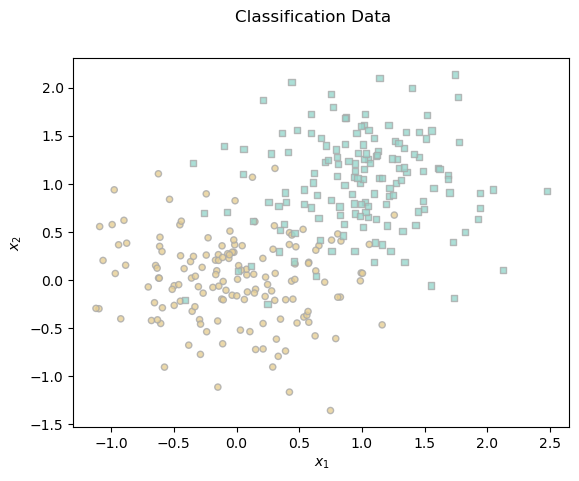

In [2]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

def plot_classification_data(X, y, ax):
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
plot_classification_data(X, y, ax)
fig.suptitle("Classification Data")


Make a function to plot decision regions:

In [3]:
def plot_decision_boundary(model, X, y, ax=None, highlight=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    x1 = torch.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 101)
    x2 = torch.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 101)

    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

    grid = torch.stack([X1.ravel(), X2.ravel()], dim=1)

    # Append column of ones to match model input shape (for intercept)
    grid = torch.cat([grid, torch.ones(grid.shape[0], 1)], dim=1)

    preds = model.score(grid).reshape(X1.shape)

    # Decision boundary plot
    ax.contourf(X1, X2, preds, levels=50, cmap="BrBG", alpha=0.8)
    ax.contour(X1, X2, preds, levels=[0.0], colors='black', linewidths=2)

    # Plot original data
    plot_classification_data(X, y, ax)


## Train Model

### Gradient Descent without Momentum

For our frist itteration, we will train our model with a learning rate (alpha) of .1, and a beta of 0. This means we are performing a logistic regression without momentum.

In [4]:

# instantiate a model and an optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

for _ in range(10000):
    loss_vec.append(LR.loss(X, y).item())
    opt.step(X, y, alpha = 0.1, beta = 0)





With our training complete, lets plot the loss over time

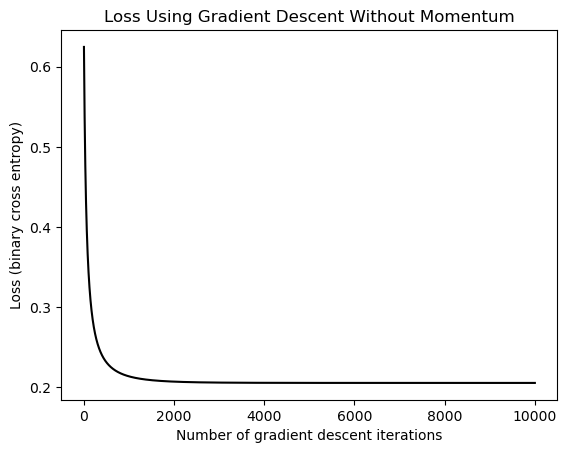

In [5]:
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.title("Loss Using Gradient Descent Without Momentum")
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

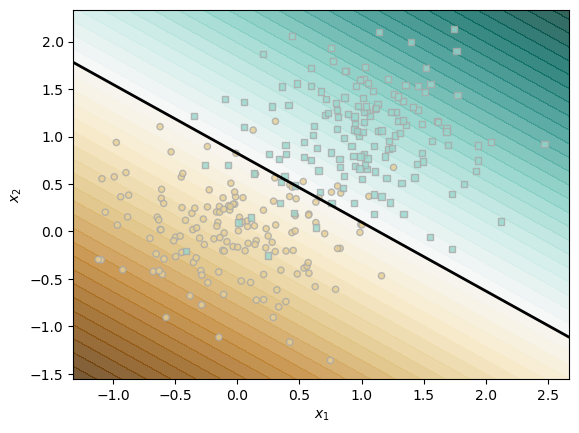

In [6]:
plot_decision_boundary(LR, X, y)

A Logistic regression, as demonstrated by the graph above, is going to be limited in the loss it can achieve by the noise within the data. There is no line that would perfectly separate this data without any feature mapping. 

### Gradient Descent with Momentum

Now let's train our model on the same data, but this time we will use a beta of .9.

In [7]:
# instantiate a model and an optimizer
LR_momentum = LogisticRegression() 
opt_momentum = GradientDescentOptimizer(LR_momentum)

# for keeping track of loss values
loss_vec_momentum = []

for _ in range(10000):
    loss_vec_momentum.append(LR_momentum.loss(X, y).item())
    opt_momentum.step(X, y, alpha = 0.1, beta = 0.9)

With the model trained, let's plot the two loss vectors on the same plot to compare.

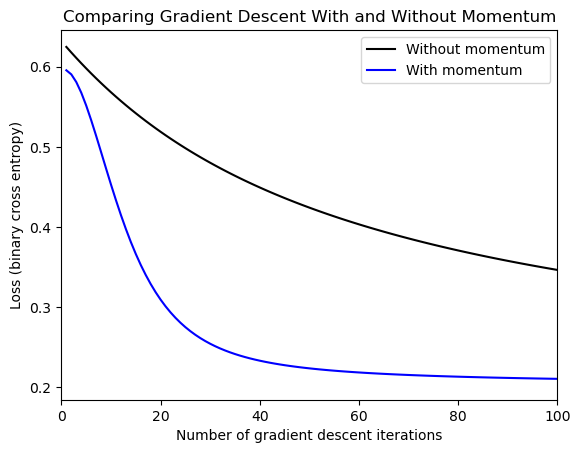

In [8]:
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.plot(torch.arange(1, len(loss_vec_momentum)+1), loss_vec_momentum, color = "blue")

plt.title("Comparing Gradient Descent With and Without Momentum")
plt.legend(["Without momentum", "With momentum"])
plt.xlim(0, 100)
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

As we can see from the above graph, with momentum our model reaches the minimum loss (Variance/noise of the date) much faster. In-fact, within 100 iterations, the without momentum model does not reach the variance of the data.(minimum loss)

However, if given enough time, both models will converge on the minimum loss:

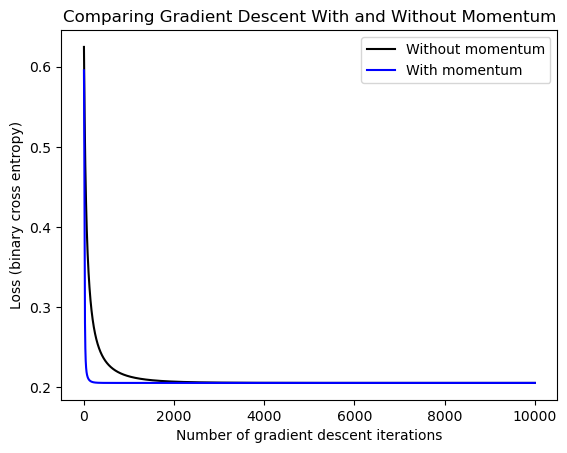

In [9]:
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.plot(torch.arange(1, len(loss_vec_momentum)+1), loss_vec_momentum, color = "blue")

plt.title("Comparing Gradient Descent With and Without Momentum")
plt.legend(["Without momentum", "With momentum"])

labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

## Overfitting

Now we are going to generate a new set of data that. Let's generate 2 sets of data with 2 times as many `p_dims` as `n_points`

In [10]:

X_train, y_train = classification_data(noise = 0.5, n_points=50, p_dims=100)

X_test, y_test = classification_data(noise = 0.5, n_points=50, p_dims=100)

#### Train Model on Training Data

We will now use our `X_train` and `y_train` data to train a model to 100% accuracy in order to demonstrate the concept of overfitting. 

In [11]:
LR_overfit = LogisticRegression() 
opt_overfit = GradientDescentOptimizer(LR_overfit)

In [13]:
loss_vec_train = []
for _ in range(100):
    loss = LR_overfit.loss(X_train, y_train).item()
    loss_vec_train.append(loss)
    opt_overfit.step(X_train, y_train, alpha = 0.1, beta = 0.9)

print("Final training loss: ", loss_vec_train[-1])

Final training loss:  0.0025839933659881353


With our Gradient Descent with Momentum optimization complete, let's look at how the loss changed over time:

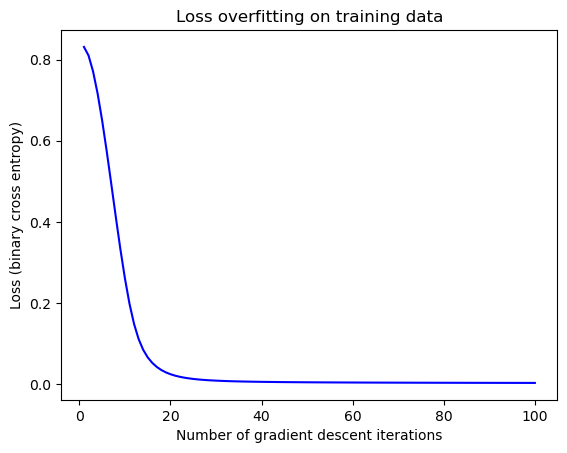

In [14]:
plt.plot(torch.arange(1, len(loss_vec_train)+1), loss_vec_train, color = "blue")
plt.title("Loss overfitting on training data")
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

As we can see, our loss approached 0 within a very few number of gradient descent iterations. Now let's test our accuracy:

In [15]:
train_acc = ((LR_overfit.predict(X_train) == y_train)*1.0).mean().item()

print("Training accuracy: ", train_acc)


Training accuracy:  1.0


Great, our training accuracy is 100% as expected! Let's test the accuracy on the test data.

In [16]:
test_acc = ((LR_overfit.predict(X_test) == y_test)*1.0).mean().item()

print("Test accuracy: ", test_acc)

Test accuracy:  0.8799999952316284


Hmmm, so it seems that we have over-fit our model quite considerably. Our test accuracy is ~.16 worse than our training accuracy of 1.

## Performance on Empirical Data (Wisconsin Breast Cancer Diagnostic):

The [data](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) from `load_breast_cancer` dataset is from the Wisconsin (diagnostic) breast cancer dataset. The features in this data were calculated from imaging of breast masses, and describe characteristics of the cell in the image.

In [17]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)




/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This dataset has a unique identifier (id), 28 anonymized features about the transaction, the transaction amount, and the class. The class is 1 if the transaction is fraudulent and 0 if not.

#### Train, Validation, Test split

Now we split our data into Training, Validation, and Testing datasets using `train_test_split` frm `sklearn`. Data is split 60%, 20%, 20% respectively:

In [18]:
from sklearn.model_selection import train_test_split
# split train and test .6 and .4
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# splite temp into validation and test sets at .5 and .5
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In order to use this data on our Logistic Regression model we need to convert it into `torch.Tensor`'s:

In [19]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # or float32 for regression

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)



In [20]:
X_train.size()

torch.Size([341, 30])

Now we can train our Logisitc Regression Model on this data:

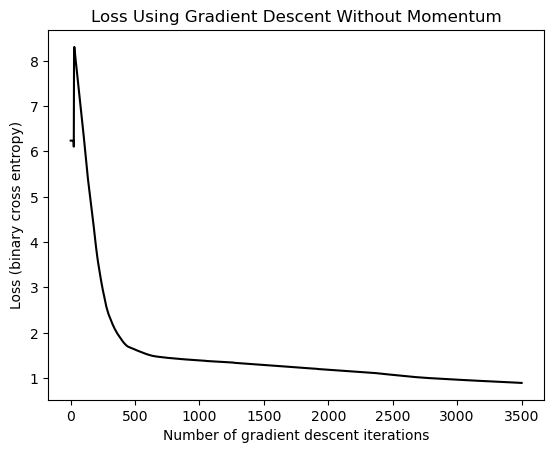

In [28]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)
loss_vec_train = []

for _ in range(3500):
    loss = LR.loss(X_train, y_train).item()
    loss_vec_train.append(loss)
    opt.step(X_train, y_train, alpha = 0.00005, beta = 0)


plt.plot(torch.arange(1, len(loss_vec_train)+1), loss_vec_train, color = "black")
plt.title("Loss Using Gradient Descent Without Momentum")
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

Great, our loss after 3500 iterations with a learning rate of 0.0005 and a beta of 0 levels out around a loss of 1. 

Let's see how it performs with momentum:

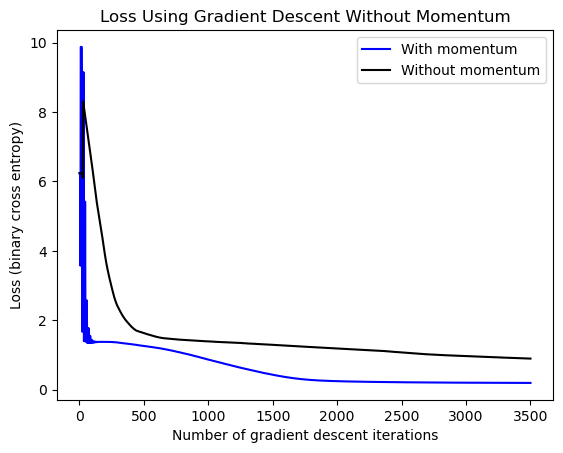

In [30]:
LRm = LogisticRegression()
opt_m = GradientDescentOptimizer(LRm)
loss_vec_train_m = []

for _ in range(3500):
    loss = LRm.loss(X_train, y_train).item()
    loss_vec_train_m.append(loss)
    opt_m.step(X_train, y_train, alpha = 0.00005, beta = 0.9)


plt.plot(torch.arange(1, len(loss_vec_train_m)+1), loss_vec_train_m, color = "blue")
plt.plot(torch.arange(1, len(loss_vec_train)+1), loss_vec_train, color = "black")
plt.title("Loss Using Gradient Descent Without Momentum")
plt.legend(["With momentum", "Without momentum"])
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

Our model reaches a lower loss on the training data when using momentum. Even though it does not make constant progress, it reaches a lower loss in fewer iterations. It is interesting to note how low the learning rate (alpha) had to be in order for this model to reach a good loss.

Lets test this model, with momentum on our training data:


In [32]:
train_acc = ((LRm.predict(X_train) == y_train)*1.0).mean().item()

print("Test accuracy with momentum: ", train_acc)
train_acc = ((LR.predict(X_train) == y_train)*1.0).mean().item()

print("Test accuracy without momentum: ", train_acc)

Test accuracy with momentum:  0.9149560332298279
Test accuracy without momentum:  0.8504399061203003


Adding momentum gives us a slightly more accurate model on the training data, so we will use momentum going forward.

#### Validation

If we use a more robust method than above however, we can probably improve our accuracy by finding the best momentum (beta) and learning rate (alpha). We do this below by selecting samples of alphas and betas and finding the best combination.

In [33]:
learning_rates = [
    1e-6, 3e-6,
    1e-5, 3e-5,
    1e-4, 3e-4,
    1e-3, 3e-3,
    1e-2, 3e-2,
    
]
betas = [
    0.0, 0.1,
    0.3, 0.5,
    0.7, 0.9,
    0.99, 0.999,
]

best_loss = 1e10
best_alpha = None
best_beta = None

for beta in betas:
    best_loss_per_beta = 1e10
    best_alpha_per_beta = None
    beta_loss_vec = []
    for alpha in learning_rates:
        LR = LogisticRegression()
        opt = GradientDescentOptimizer(LR)
        loss_vec_train = []
        for _ in range(400):
            loss = LR.loss(X_train, y_train).item()
            loss_vec_train.append(loss)
            
            opt.step(X_train, y_train, alpha = alpha, beta = 0.9)
        if loss_vec_train[-1] < best_loss:
            best_loss_per_beta = loss_vec_train[-1]
            best_alpha_per_beta = alpha
        
    if best_loss_per_beta < best_loss:
        best_loss = best_loss_per_beta
        best_alpha = best_alpha_per_beta
        best_beta = beta
      

In [34]:
print("Best learning rate: ", best_alpha)
print("Best beta: ", best_beta)
print("Best loss: ", best_loss)

Best learning rate:  0.0003
Best beta:  0.999
Best loss:  0.6386049389839172


In validation, we are able to find our best learning rate and best beta to minimize our loss. Let's now train our model on the training data, and we will track the loss on the validation and training data overtime so we can compare them.

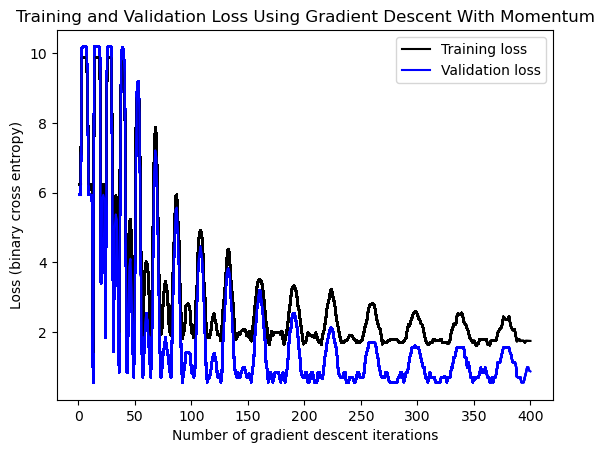

In [35]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)
loss_vec_train = []
loss_vec_val = []
for _ in range(400):
    loss = LR.loss(X_train, y_train).item()
    loss_val = LR.loss(X_val, y_val).item()
    loss_vec_val.append(loss_val)
    loss_vec_train.append(loss)
    opt.step(X_train, y_train, alpha = best_alpha, beta = best_beta)
    plt.plot(torch.arange(1, len(loss_vec_train)+1), loss_vec_train, color = "black")
    plt.plot(torch.arange(1, len(loss_vec_val)+1), loss_vec_val, color = "blue")
plt.title("Training and Validation Loss Using Gradient Descent With Momentum")
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")
plt.legend(["Training loss", "Validation loss"])


Surprisingly, our model performs better on the validation data than on the training data. Let's check our accuracy on the validation data with our best alpha and beta values:

In [36]:
train_acc = ((LR.predict(X_train) == y_train)*1.0).mean().item()

print("Train accuracy: ", train_acc)

val_acc = ((LR.predict(X_val) == y_val)*1.0).mean().item()

print("Validation accuracy: ", val_acc)



Train accuracy:  0.8914955854415894
Validation accuracy:  0.9385964870452881


As we can see our model did even better on the validation data than on the training data. This is a great sign, and hopefully translates to our testing data as well. 

### Testing

I think we can see how we have done on the testing data now:

In [37]:
test_acc = ((LR.predict(X_test) == y_test)*1.0).mean().item()

print("Test accuracy without momentum: ", test_acc)

Test accuracy without momentum:  0.9736841917037964


We have achieved an incredibly high accuracy on our testing data! Yay. 

# Discussion:

In this blog post, I have explored the process of first implementing logistic regression, and then exploring its various components. Starting with generated data, I explored the benefits of using momentum in order to more quickly achieve a lower loss than when using vanilla gradient descent. Then using a new generated dataset, with significant noise, fewer points, and many data points, overfitting was explored. With more features, and fewer points our model achieved 100% accuracy on the testing data but then performed much more poorly on the testing data. It was a good reminder that if your loss is lower than the variance or noise on the training data that you are probably overfitting your model.

Then the concepts learned were applied to the wisconsin breast cancer dataset. first I did a simple comparison of vanilla gradient descent on this data compared to with momentum to show the difference. In order to reach the highest accuracy possible however, I then optimized both the beta and alpha values while tracking the loss. With the best values found, I then trained on the training data and tracked the loss for the validation data and training data at every step. Surprisingly, the data did better on the validation and testing data than on the training data. THis is a great sign for the model in my opinion, and a signal that there were some very tricky data points in the training data that the model did not overfit to. 